In [19]:
import pandas as pd 
import json
import numpy as np

In [20]:
#Lecture des données
tunisian_stock_market = 'Tunisian-Stock-Market.json'
with open(tunisian_stock_market, 'r') as json_file:
    
    json_data = json.load(json_file)
TunisianStockMarket = pd.DataFrame(json_data)

In [21]:
#Choix d'une seule action(BNA dans notre cas)
TunisianStockMarket['Date'] = pd.to_datetime(TunisianStockMarket['Date'])
bna_data = TunisianStockMarket[TunisianStockMarket['Stock_name'] == 'POULINA']

In [22]:
#Filtrage des colonnes non utile
columnsToExclude = ['Code_isin','Stock_name']
TunisianStockMarketFiltred = bna_data.drop(columns=columnsToExclude)
filtered_data = TunisianStockMarketFiltred[TunisianStockMarketFiltred['Date'].dt.year.isin([2020, 2021])]
print(TunisianStockMarketFiltred)

             Date  Adj_Close  Adj_low  Adj_High         Volume
51     2021-11-04     12.200   12.200    12.200      36.599998
130    2021-11-03     12.200   12.200    12.200      85.400002
209    2021-11-02     12.200    0.000     0.000       0.000000
288    2021-11-01     12.200   12.200    12.200    3794.199951
367    2021-10-29     11.900   11.890    12.000   35895.007812
...           ...        ...      ...       ...            ...
198634 2011-01-07      6.388    6.257     6.388  568643.875000
198690 2011-01-06      6.250    6.237     6.277   20830.900391
198746 2011-01-05      6.263    6.250     6.263   37544.601562
198802 2011-01-04      6.257    6.152     6.257   17448.449219
198858 2011-01-03      6.257    6.119     6.283  131425.953125

[2689 rows x 5 columns]


In [23]:
#Function to make date format to datetime
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year , month , day = int(split[0]) , int(split[1]) , int(split[2])
    return datetime.datetime(year=year , month=month , day=day)

In [24]:
#TunisianStockMarketFiltred['Date'] = TunisianStockMarketFiltred['Date'].apply(str_to_datetime)
#TunisianStockMarketFiltred['Date']

In [25]:
TunisianStockMarketFiltred.index = TunisianStockMarketFiltred.pop('Date')
TunisianStockMarketFiltred

,Adj_Close,Adj_low,Adj_High,Volume
Date,,,,
2021-11-04,12.200,12.200,12.200,36.599998
2021-11-03,12.200,12.200,12.200,85.400002
2021-11-02,12.200,0.000,0.000,0.000000
2021-11-01,12.200,12.200,12.200,3794.199951
2021-10-29,11.900,11.890,12.000,35895.007812
...,...,...,...,...
2011-01-07,6.388,6.257,6.388,568643.875000
2011-01-06,6.250,6.237,6.277,20830.900391
2011-01-05,6.263,6.250,6.263,37544.601562


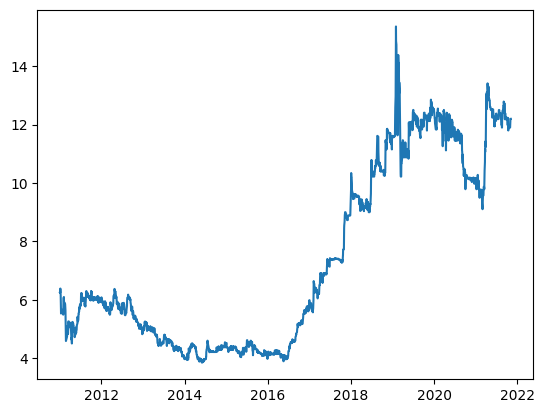

In [26]:
import matplotlib.pyplot as plt 

plt.plot(TunisianStockMarketFiltred.index , TunisianStockMarketFiltred['Adj_Close'])

In [27]:
#Create windowed data every 3 days
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Adj_Close'].shift(i)
    windowed_data['Target'] = data['Adj_Close']
    return windowed_data.dropna()


windowed_data = window_data(TunisianStockMarketFiltred, n = 3)
windowed_data.sort_index(inplace=True, ascending=True)
windowed_data

,Target-3,Target-2,Target-1,Target
Date,,,,
2011-01-03,6.250,6.263,6.257,6.257
2011-01-04,6.388,6.250,6.263,6.257
2011-01-05,6.145,6.388,6.250,6.263
2011-01-06,5.961,6.145,6.388,6.250
2011-01-07,5.790,5.961,6.145,6.388
...,...,...,...,...
2021-10-26,11.900,11.900,11.900,11.900
2021-10-27,12.200,11.900,11.900,11.900
2021-10-28,12.200,12.200,11.900,11.900


In [28]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = windowed_dataframe.index.values

  middle_matrix = df_as_np[:, 0:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_data)

dates.shape, X.shape, y.shape


((2686,), (2686, 3, 1), (2686,))

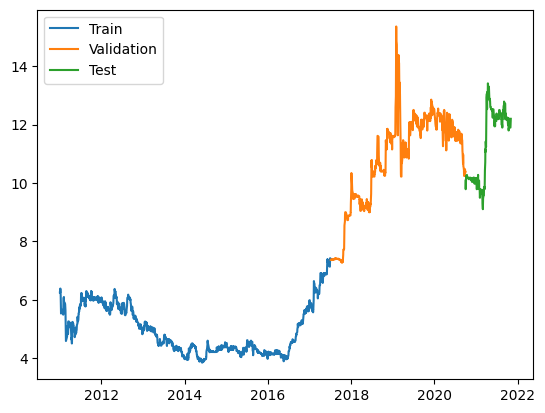

In [29]:
q_80 = int(len(dates) * .6)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [30]:
from tensorflow.keras.models import Sequential #Sequential model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 
import distutils



model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32 , activation='relu'),
                    layers.Dense(32 , activation='relu'),
                    layers.Dense(1)])

model.compile(loss='MSE' ,
               optimizer=Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])

model.fit(X_train, y_train , validation_data = (X_val , y_val) , epochs=100)


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 17.3622 - mean_absolute_error: 3.9172 - val_loss: 14.9705 - val_mean_absolute_error: 3.5977
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3291 - mean_absolute_error: 0.4652 - val_loss: 20.7784 - val_mean_absolute_error: 4.3401
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1561 - mean_absolute_error: 0.3301 - val_loss: 17.1348 - val_mean_absolute_error: 3.9169
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1011 - mean_absolute_error: 0.2679 - val_loss: 14.1121 - val_mean_absolute_error: 3.5343
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0591 - mean_absolute_error: 0.1975 - val_loss: 11.1060 - val_mean_absolute_error: 3.1068
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0283 - mean_absolute_error: 0.1294 - val_loss: 8.9000 - val_mean_absolute_error: 2.7536
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190 - mean_absolute_error: 0.0985 - va

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


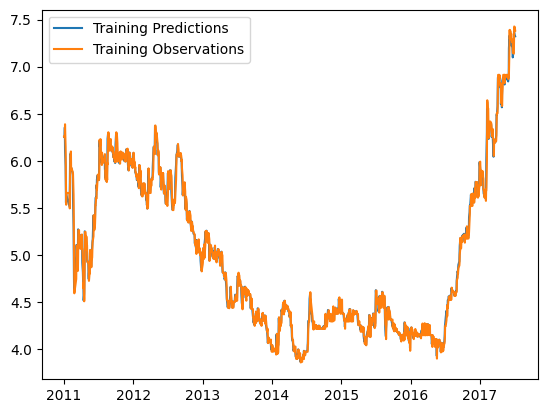

In [31]:
train_prediction = model.predict(X_train).flatten()

plt.plot(dates_train , train_prediction)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions' , 'Training Observations'])

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


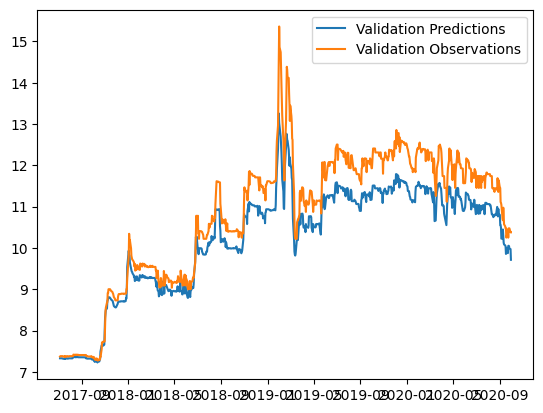

In [32]:
val_prediction = model.predict(X_val).flatten()

plt.plot(dates_val , val_prediction)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions' , 'Validation Observations'])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


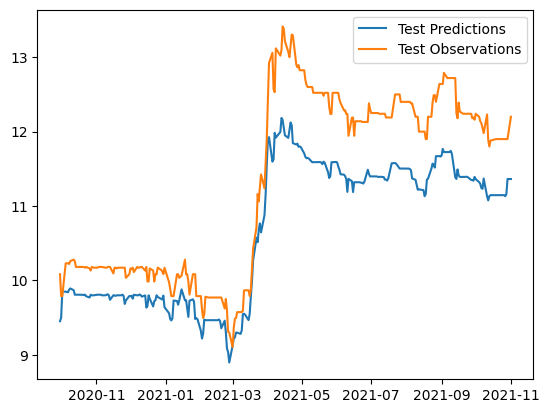

In [33]:
test_prediction = model.predict(X_test).flatten()

plt.plot(dates_test , test_prediction)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions' , 'Test Observations'])

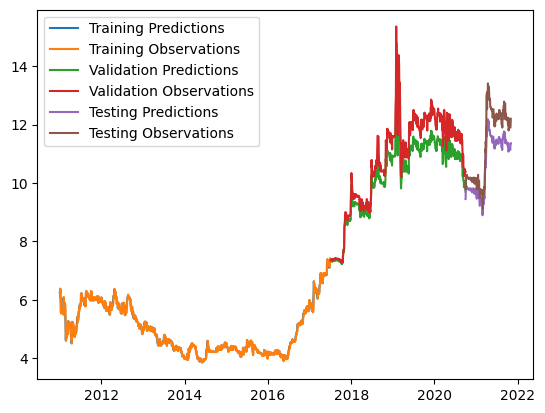

In [34]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [35]:
from copy import deepcopy

recursive_predictions = []
recursive_dates=np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    next_prediction=model.predict(np.array([last_window[-3:]])).flatten()
    recursive_predictions.append(next_prediction)
    last_window=np.concatenate((last_window,[next_prediction]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

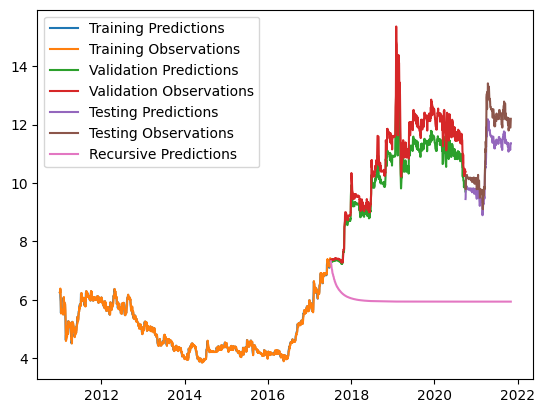

In [37]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])